In [1]:
# allow the notebook to access the parent directory so we can import the other modules
# https://stackoverflow.com/a/35273613
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Data Preparation
-----

### Constants and Folder Paths

In [2]:
import os
dataset_folder_path = os.path.join("..", "files", "dataset")

In [3]:
from data.DataSet import DataSet
dataset = DataSet()
dataset.load(dataset_folder_path, test_set_percentage=0.2, validation_set_percentage=0.3333)

print("Training Data Len:", len(dataset.train_data))
print("Validation Data Len:", len(dataset.valid_data))
print("Test Data Len:", len(dataset.test_data))

36 files found!
Training Data Len: 1900
Validation Data Len: 1000
Test Data Len: 700


### Data Preprocessing

In [4]:
NUM_SAMPLES = 50
ANGLES_TO_ROTATE = [5, 10, 15, 45, -5, -10, -15, -45]

In [5]:
from utils.preprocessing import *
from functools import partial
dataset.apply(apply_mean_centering)
dataset.apply(apply_unit_distance_normalization)
dataset.apply(partial(spline_interpolate_and_resample, num_samples=NUM_SAMPLES))
dataset.expand_many(partial(rotate_digit, degrees=ANGLES_TO_ROTATE))
dataset.expand(reverse_digit_sequence)

print("Training Data Len:", len(dataset.train_data))
print("Validation Data Len:", len(dataset.valid_data))
print("Test Data Len:", len(dataset.test_data))

Training Data Len: 34200
Validation Data Len: 18000
Test Data Len: 12600


### Split Dataset into *Train*, *Valid*, and *Test*

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train = np.array(dataset.train_data)
X_valid = np.array(dataset.valid_data)
X_test = np.array(dataset.test_data)

# Convert labels to numpy array and OneHot encode them
encoder, Y_train, Y_valid, Y_test = dataset.onehot_encode_labels()

print("Training Data Shape:", X_train.shape)
print("Training Labels Shape:", Y_train.shape)
print("Validation Data Shape:", X_valid.shape)
print("Validation Labels Shape:", Y_valid.shape)
print("Test Data Shape:", X_test.shape)
print("Test Labels Shape:", Y_test.shape)

Training Data Shape: (34200, 50, 2)
Training Labels Shape: (34200, 10)
Validation Data Shape: (18000, 50, 2)
Validation Labels Shape: (18000, 10)
Test Data Shape: (12600, 50, 2)
Test Labels Shape: (12600, 10)


----------
# Neural Network Setup and Training
----------

## **Regularized 1024 GRU**

### Parameters

In [7]:
PARAM_NUM_EPOCHS = 20
PARAM_BATCH_SIZE = 300

### Setup Model

In [8]:
from models.regularized_1024_gru import Regularized1024GRU
import os.path

mymodel = Regularized1024GRU(X_train.shape[1:], output_path=os.path.join("..", "files"))
mymodel.batch_size = PARAM_BATCH_SIZE
mymodel.num_epochs = PARAM_NUM_EPOCHS
mymodel.initialize()
print(mymodel)

Using TensorFlow backend.




----------

Optimizer: <class 'keras.optimizers.Nadam'>
Batch Size: 300
Number of Epochs: 20

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 50, 1024)          3154944   
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 1024)          0         
_________________________________________________________________
gru_2 (GRU)                  (None, 1024)              6294528   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
______________________________________________

#### Save Model Summary

In [9]:
mymodel.save_summary(dataset.get_recorded_operations())
mymodel.save_config()

Summary saved to ../files/checkpoints/1525270482.2365336/summary.txt
Model config saved to ../files/checkpoints/1525270482.2365336/model.txt


### Train Model

In [ ]:
mymodel.train(X_train, Y_train, X_valid, Y_valid)

Train on 34200 samples, validate on 18000 samples
Epoch 1/20
 7200/34200 [=====>........................] - ETA: 51s - loss: 2.0148 - categorical_accuracy: 0.2454

### Evaluate Model

#### Test Set Accuracy

In [30]:
test_score = tuple(mymodel.model.evaluate(X_test, Y_test))
print("Test Loss: %.3f, Test Acc: %.3f%%" % (test_score[0], test_score[1] * 100))

2400/2400 [==============================] - 1s 491us/step
Test Loss: 0.338, Test Acc: 90.000%


#### Recall, Precision, F1_Score on Validation set

In [31]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_valid = mymodel.model.predict_classes(X_valid, verbose=1)
rpf_valid = get_evaluation_metrics(Y_valid, Y_predicted_valid)
rpf_valid

1200/1200 [==============================] - 1s 602us/step


,recall,precision,f1 score,#
0,0.967480,0.991667,0.979424,120.0
1,0.966387,0.958333,0.962343,120.0
2,0.880342,0.858333,0.869198,120.0
3,0.991525,0.975000,0.983193,120.0
4,0.936508,0.983333,0.959350,120.0
5,0.927273,0.850000,0.886957,120.0
6,1.000000,0.975000,0.987342,120.0
7,0.972727,0.891667,0.930435,120.0
8,0.900000,0.975000,0.936000,120.0
9,0.900000,0.975000,0.936000,120.0


Average F1 Score for Validation Set

In [32]:
rpf_valid.mean()

recall         0.944224
precision      0.943333
f1 score       0.943024
#            120.000000
dtype: float64

#### Recall, Precision, F1_Score on Test set

In [33]:
from utils.evaluation import get_evaluation_metrics, get_confusion_matrix

Y_predicted_test = mymodel.model.predict_classes(X_test, verbose=1)
rpf_test = get_evaluation_metrics(Y_test, Y_predicted_test)
rpf_test

2400/2400 [==============================] - 1s 477us/step


,recall,precision,f1 score,#
0,0.926070,0.991667,0.957746,240.0
1,0.912863,0.916667,0.914761,240.0
2,0.916667,0.733333,0.814815,240.0
3,0.955285,0.979167,0.967078,240.0
4,0.869888,0.975000,0.919450,240.0
5,0.922374,0.841667,0.880174,240.0
6,0.973333,0.912500,0.941935,240.0
7,0.919048,0.804167,0.857778,240.0
8,0.794964,0.920833,0.853282,240.0
9,0.844106,0.925000,0.882704,240.0


Average F1 Score for Test Set

In [34]:
rpf_test.mean()

recall         0.903460
precision      0.900000
f1 score       0.898972
#            240.000000
dtype: float64

##### Increase default plotsize for matplotlib

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

#### Plot Validation Set Confusion Matrix

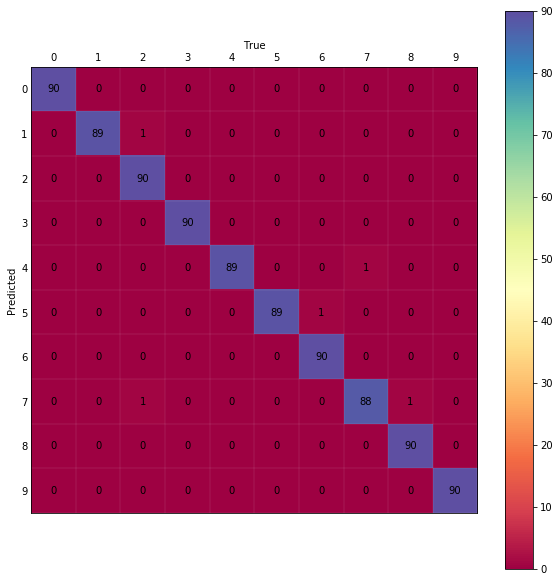

In [17]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_valid, Y_predicted_valid, plot=True)

#### Plot Test Set Confusion Matrix

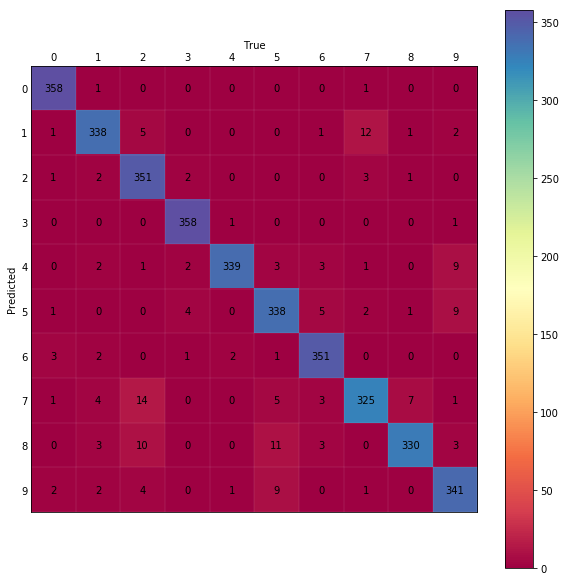

In [18]:
from utils.evaluation import get_confusion_matrix
# Confusion Matrix
confmat = get_confusion_matrix(Y_test, Y_predicted_test, plot=True)

# Backup Code
-----

In [11]:
from keras.models import load_model
mymodel.model = load_model("checkpoints/1523369406.7123575/naive_overfit_gru-30-0.97.hdf5")